# Creating a Similar Songs Network

*Moses Surumen, Ellen Peng, Kuhuk Goyal*  
*CS 194-31  Final Project*  
*Project Name: Music Networks*

---

## Introduction

The **Million Song Dataset (MSD)** is a freely-available collection of audio features and metadata for a million contemporary popular music tracks. It contains track, song, artist, and album metadata as well as artist similarity and artist tags. The data is stored in HDF5 format, with one file per song.

The dataset was created using the [**Echo Nest**](http://the.echonest.com/) API. More information on the dataset can be found [here](http://labrosa.ee.columbia.edu/millionsong/).


---

In [2]:
# Pandas
import pandas as pd

# Graph
import community
import networkx as nx

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Combinations
import itertools

---
##  Dataset Format

| Column        | Description                            | Format
| :------------ |--------------------------------------: | :-:
| a_similar     | Similar artists                        | array('artistId', 'artistId', ... , 'artistId')
| artist_7did   | Seven digit artist ID                  | 
| artist_id     | Echo Nest artist ID                    | 
| artist_mbid   | Music Brain artist ID                  | 
| artist_name   | Name of the artist                     | string
| dance         | Danceability of the song               | float
| dur           | Duration of the song                   | float
| energy        | Energy of the song                     | float
| song_id       | Echo Nest song ID                      | 
| title         | The title of the song                  |
| track_id      | Echo Nest track ID                     |
| year          | The year the song was released         |






---

## Get Data

In [3]:
df = pd.read_csv('data/similar_songs.csv')

In [4]:
df.head()

,TRARRUZ128F9307C57,TRGGBUV128F930B5F6,1
0,TRARRUZ128F9307C57,TRKJAYK128F930B613,0.985081
1,TRARRUZ128F9307C57,TRHSFCB128F428D093,0.190086
2,TRARRUZ128F9307C57,TRGJYWK128F428D09A,0.006668
3,TRARRUZ128F9307C57,TRRCYEK128F92F930C,0.006554
4,TRARRUZ128F9307C57,TRBDVWE128F92F930A,0.006554


___

## Create Graph

In [5]:
G = nx.Graph()

In [6]:
# Print graph size
print('\nSize of graph, i.e. number of edges:', G.size())


Size of graph, i.e. number of edges: 0


In [7]:
for index, row in df.iterrows():
    if row[2] >= 0.7:
        G.add_edge(row[0], row[1], weight=row[2], length=1.0)
#         G.node[row[0]]['name'] = row[3]
#         G.node[row[1]]['name'] = row[4]

In [8]:
# Print graph size
print('\nSize of graph, i.e. number of edges:', G.size())


Size of graph, i.e. number of edges: 21786


In [12]:
A_WHOLE = nx.adjacency_matrix(G)

___

## Compute best partition

In [9]:
# Get best partition
partition = community.best_partition(G)
print('Modularity: ', community.modularity(partition, G))

Modularity:  0.991105918116882


## Draw Graph to Gephi

In [26]:
nx.write_gexf(G, "network.gexf")

___

## Filter communities

Choose partitions with at least 25 songs, and at most 50 songs

In [10]:
# Keep only communities with a minimum of songs
centers = {}
communities = {}
G_main_com = G.copy()
min_songs = 25
# max_songs = 50
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    if len(list_nodes) < min_songs:
        G_main_com.remove_nodes_from(list_nodes)
    else:
        # Get center
        H = G_main_com.subgraph(list_nodes)
        d_c = nx.degree_centrality(H)
        center = max(d_c, key=d_c.get)
        centers[center] = com
        communities[com] = center
        # Print community
#         print('Community of ', center , '(ID ', com, ') - ', len(list_nodes), ' songs:')
#         print(list_nodes, '\n')

In [30]:
nx.write_gexf(G_main_com, "partitions.gexf")

In [11]:
nodes_main_com = {k: v for k, v in partition.items() if v in communities}
ind = community.induced_graph(nodes_main_com, G_main_com)
# print('Number of communities', len(ind.nodes()))
# print('\nMain communities and their center node:', communities)

## Display graph

/Users/moses/miniconda3/envs/16b/lib/python3.6/site-packages/networkx/drawing/layout.py:499: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt((delta**2).sum(axis=0))


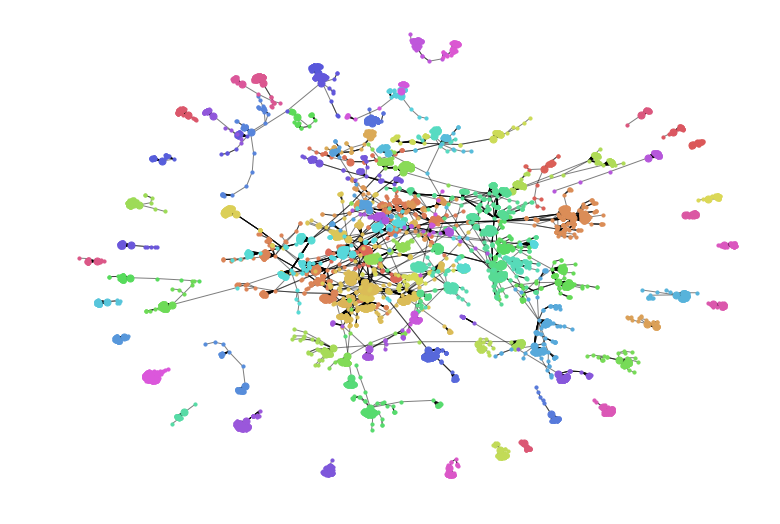

In [43]:
plt.figure(figsize=(13, 9))
node_size = 10
count = 0
pos = nx.spring_layout(G_main_com)
colors = dict(zip(communities.keys(), sns.color_palette('hls', len(communities.keys()))))

for com in communities.keys():
    count = count + 1
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com and nodes not in communities.values()]
    nx.draw_networkx_nodes(G_main_com, pos, list_nodes, node_size = node_size, node_color = colors[com])
    nx.draw_networkx_nodes(G_main_com, pos, list([communities[com]]), node_size = node_size*5, node_color = colors[com])
nx.draw_networkx_edges(G_main_com, pos, alpha=0.5)
labels = {k: str(v) + ': ' + k for k,v in centers.items()}
plt.axis('off')
plt.savefig("communities_viz.png", dpi=1000)
plt.show()

In [32]:
nx.write_gexf(ind, "induced.gexf")

## Display induced graph

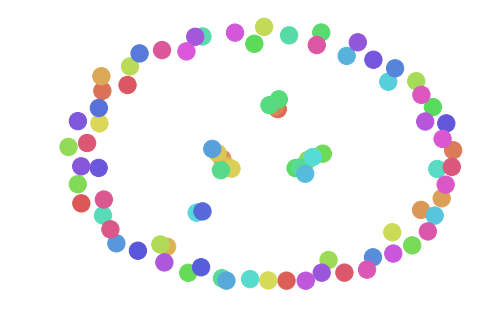

In [36]:
pos_ind = nx.spring_layout(ind)
colors = dict(zip(communities.keys(), sns.color_palette('hls', len(communities.keys()))))
labels = {k: str(k) + ': ' + v for k,v in communities.items()}
nx.draw(ind, pos_ind, node_list=list(colors.keys()), node_color=list(colors.values()))
plt.show()